# Semi-Analytic Solution for Simply-Supported, Rectangular Kirchhoff Plates

We will calculate deflections, strains, internal forces, stresses and utilizations for a Mindlin plate. We are also going to visualize the stresses using PyVista.

In [20]:
from numpy import ascontiguousarray as ascont

from sigmaepsilon.mesh.grid import grid
from sigmaepsilon.mesh import triangulate
from sigmaepsilon.mesh.utils.topology.tr import Q4_to_T3

from sigmaepsilon.solid.material import MindlinPlateSection as Section
from sigmaepsilon.math.linalg import ReferenceFrame
from sigmaepsilon.solid.material import (
    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion_SP,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix

from sigmaepsilon.solid.fourier import (
    RectangularPlate,
    LoadGroup,
    PointLoad,
    RectangleLoad,
)

size = Lx, Ly = (600.0, 800.0)
E = 2890.0
nu = 0.2
t = 25.0
yield_strength = 25.0

hooke = elastic_stiffness_matrix(E=E, NU=nu)
frame = ReferenceFrame(dim=3)
stiffness = ElasticityTensor(hooke, frame=frame, tensorial=False)

failure_model = HuberMisesHenckyFailureCriterion_SP(yield_strength=yield_strength)

material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)

section = Section(
    layers=[
        Section.Layer(material=material, thickness=t),
    ]
)
ABDS = section.elastic_stiffness_matrix()
D, S = ascont(ABDS[:3, :3]), ascont(ABDS[3:, 3:])

loads = LoadGroup(
    LG1=LoadGroup(
        LC1=RectangleLoad(x=[[0, 0], [Lx, Ly]], v=[-0.1, 0, 0]),
        LC2=RectangleLoad(x=[[Lx / 3, Ly / 2], [Lx / 2, 2 * Ly / 3]], v=[-1, 0, 0]),
    ),
    LG2=LoadGroup(
        LC3=PointLoad(x=[Lx / 3, Ly / 2], v=[-100.0, 0, 0]),
        LC4=PointLoad(x=[2 * Lx / 3, Ly / 2], v=[100.0, 0, 0]),
    ),
)
loads.lock()

shape = nx, ny = (240, 320)
gridparams = {"size": size, "shape": shape, "eshape": "Q4"}
coords, topo = grid(**gridparams)
coords, triangles = Q4_to_T3(coords, topo)
triobj = triangulate(points=coords[:, :2], triangles=triangles)[-1]

plate = RectangularPlate(size, (20, 20), D=D, S=S)
results = plate.solve(loads, coords)

## Plotting as a pointcloud

In [21]:
import numpy as np
import pyvista as pv

load_case_results = results["LG1", "LC2"].values
strains = load_case_results[:, 3:8]
z = np.linspace(-t/2, t/2, 20)
rng = (-t/2, t/2)
stresses = section.calculate_stresses(strains=strains, rng=rng, z=z).values
util, util_coords = section.utilization(strains=strains, rng=rng, z=z, coords=coords, return_coords=True)

num_XY, num_Z = util_coords.shape[:2]
util_coords = util_coords.reshape((num_XY * num_Z, 3))
util = util.values.flatten()

point_cloud = pv.PolyData(util_coords)
point_cloud["scalars"] = util

point_cloud

PolyData (0x228fe3a24c0)
  N Cells:    1547220
  N Points:   1547220
  N Strips:   0
  X Bounds:   0.000e+00, 6.000e+02
  Y Bounds:   0.000e+00, 8.000e+02
  Z Bounds:   -1.250e+01, 1.250e+01
  N Arrays:   1

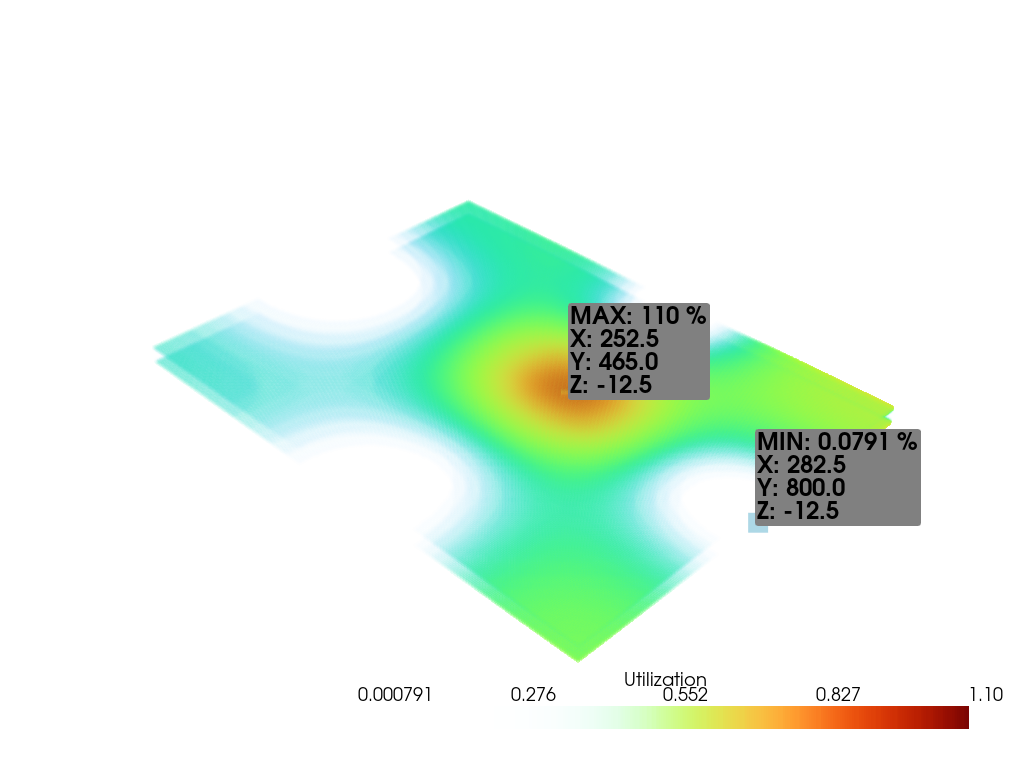

In [22]:
from sigmaepsilon.core.formatting import floatformatter 

formatter = floatformatter(sig=3)

plotter = pv.Plotter(notebook=True)

scalars = util
points = util_coords
max_index = np.argmax(scalars)
min_index = np.argmin(scalars)

p_min = point_cloud.points[min_index]
p_max = point_cloud.points[max_index]
label_coords = np.array([p_min, p_max])

labels = [
    (
        f"MIN: {formatter.format(util.min()*100)} %"
        f"\nX: {points[min_index, 0]}"
        f"\nY: {points[min_index, 1]}"
        f"\nZ: {points[min_index, 2]}"
    ), 
    (
        f"MAX: {formatter.format(util.max()*100)} %"
        f"\nX: {points[max_index, 0]}"
        f"\nY: {points[max_index, 1]}"
        f"\nZ: {points[max_index, 2]}"
        )
]

plotter.add_mesh(
    point_cloud,
    scalars='scalars',
    cmap="turbo",
    lighting=False,
    scalar_bar_args={'title': "Utilization"},
    render_points_as_spheres=True,
    opacity="sigmoid",
)

plotter.add_point_labels(label_coords, labels, point_size=20, font_size=24)

plotter.show(jupyter_backend="static")